# MovieLens recommendation tutorial
Today we are going to build on what we learned during the course, and build several types of recommender systems for the movielens dataset, you can download it right [here](https://grouplens.org/datasets/movielens/1m/).
MovieLens is a web site that helps people find movies to watch. It has hundreds of thousands of registered users. And we are going to use this dataset with 1M ratings from 6000 users on 4000 movies (it was released in 2003 so it is quite old, but there are newer versions of this dataset)

## Part 1: Data preprocessing
First we are going just to preprocess the data a bit to get it in a clear manner, and replace some of the column values by clearer values, nothing too fancy.

In [1]:
# Import packages
import os
import pandas as pd
import random

random.seed(42) 

/Users/ma.benhalloum/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ma.benhalloum/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Define directories
MOVIELENS_DIR = 'ml-1m'
USER_DATA_FILE = 'users.dat'
MOVIE_DATA_FILE = 'movies.dat'
RATING_DATA_FILE = 'ratings.dat'

In [3]:
# Specify User's Age and Occupation Column
AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }

In [4]:
# Define csv files to be saved into
USERS_CSV_FILE = 'users.csv'
MOVIES_CSV_FILE = 'movies.csv'
RATINGS_CSV_FILE = 'ratings.csv'

In [5]:
# Read the Ratings File
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Set max_userid to the maximum user_id in the ratings
max_userid = ratings['user_id'].drop_duplicates().max()
# Set max_movieid to the maximum movie_id in the ratings
max_movieid = ratings['movie_id'].drop_duplicates().max()

print(len(ratings), 'ratings loaded')

1000209 ratings loaded


In [6]:
# Let's just check what it looks like
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
# Save into ratings.csv
ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True,
               index=False,
               encoding='latin-1')
print('Saved to', RATINGS_CSV_FILE)

Saved to ratings.csv


In [8]:
# Read the Users File
users = pd.read_csv(os.path.join(MOVIELENS_DIR, USER_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])

print(len(users), 'descriptions of', max_userid, 'users loaded.')

6040 descriptions of 6040 users loaded.


In [9]:
users.head()

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


In [10]:
# Save into users.csv
users.to_csv(USERS_CSV_FILE, 
             sep='\t', 
             header=True,
             index=False,
             encoding='latin-1')
print('Saved to', USERS_CSV_FILE)

Saved to users.csv


In [11]:
# Read the Movies File
movies = pd.read_csv(os.path.join(MOVIELENS_DIR, MOVIE_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
print(len(movies), 'descriptions of', max_movieid, 'movies loaded.')

3883 descriptions of 3952 movies loaded.


In [12]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
# Save into movies.csv
movies.to_csv(MOVIES_CSV_FILE, 
              sep='\t', 
              header=True,
              index=False)
print('Saved to', MOVIES_CSV_FILE)

Saved to movies.csv


## Part 2: Movie Recommendation with Content-Based and Collaborative Filtering
“*What movie should I watch this evening?*” 

Have you ever had to answer this question at least once when you came home from work? As for me — yes, and more than once. From Netflix to Hulu, the need to build robust movie recommendation systems is extremely important given the huge demand for personalized content of modern consumers.

An example of recommendation system is such as this:
* User A watches **Game of Thrones** and **Breaking Bad**.
* User B does search on **Game of Thrones**, then the system suggests **Breaking Bad** from data collected about user A.

Recommendation systems are used not only for movies, but on multiple other products and services like Amazon (Books, Items), Pandora/Spotify (Music), Google (News, Search), YouTube (Videos) etc.

Two most ubiquitous types of personalized recommendation systems are **Content-Based** and **Collaborative Filtering**. Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In this notebook, we will attempt at implementing these two systems to recommend movies and evaluate them to see which one performs better.

### Data preparation
Let's load this data into Python. we will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **movies**.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1')

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1')

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1')

Now lets take a peak into the content of each file to understand them better.

### Ratings Dataset

In [15]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id      1000209 non-null int64
movie_id     1000209 non-null int64
rating       1000209 non-null int64
timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


This confirms that there are approximately 1M ratings for different user and movie combinations.

### Users Dataset

In [17]:
users.head()

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 7 columns):
user_id       6040 non-null int64
gender        6040 non-null object
age           6040 non-null int64
occupation    6040 non-null int64
zipcode       6040 non-null object
age_desc      6040 non-null object
occ_desc      6040 non-null object
dtypes: int64(3), object(4)
memory usage: 330.4+ KB


This confirms that there are 6040 users and we have 5 features for each (unique user ID, gender, age, occupation and the zip code they are living in).

### Movies Dataset

In [19]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


This dataset contains attributes of the 3883 movies. There are 3 columns including the movie ID, their titles, and their genres. Genres are pipe-separated and are selected from 18 genres (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western).

## Data Exploration
### Titles
Are there certain words that feature more often in Movie Titles? Let's try out a nice visualization using word clouds.

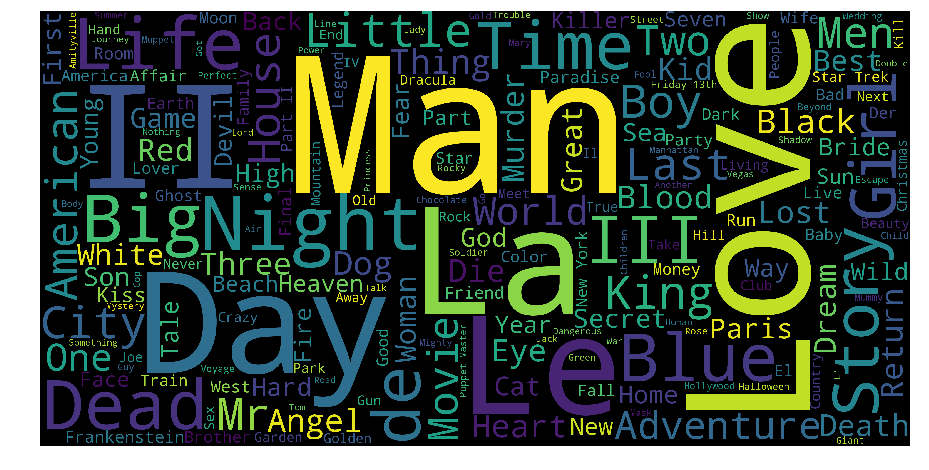

In [21]:
%matplotlib inline

import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
# we just join all the titles together into a big string
title_corpus = ' '.join(movies['title'])

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Ok maybe not the most interesting visualization in the world, but gives us an idea of what words are in the movie titles. We can see Day, Man, Love ...

### Ratings
Now let's examine the ratings a bit more. Some descriptive statistics first.

In [22]:
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

It appears that users are quite generous in their ratings. The mean rating is 3.58 on a scale of 5. Half the movies have a rating of 4 and 5. But because different people might rate on different scales, we can't really conclude.

Let's also take a look at a subset of 20 movies with the highest rating.

In [23]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies, ratings),users)

# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(10)

,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5
489237,Rushmore (1998),Comedy,5
489236,"Simple Plan, A (1998)",Crime|Thriller,5
489226,Hands on a Hard Body (1996),Documentary,5
489224,Pleasantville (1998),Comedy,5
489212,Say Anything... (1989),Comedy|Drama|Romance,5


### Genres
The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents.

In [24]:
from collections import Counter

genre_counter = Counter([genre for row in movies['genres'].apply(lambda s: s.split('|')).values for genre in row])

In [25]:
genre_counter.most_common(5)

[('Drama', 1603),
 ('Comedy', 1200),
 ('Action', 503),
 ('Thriller', 492),
 ('Romance', 471)]

The top 5 genres are, in that respect order: Drama, Comedy, Action, Thriller, and Romance. Let's visualize them in a wordcloud again.

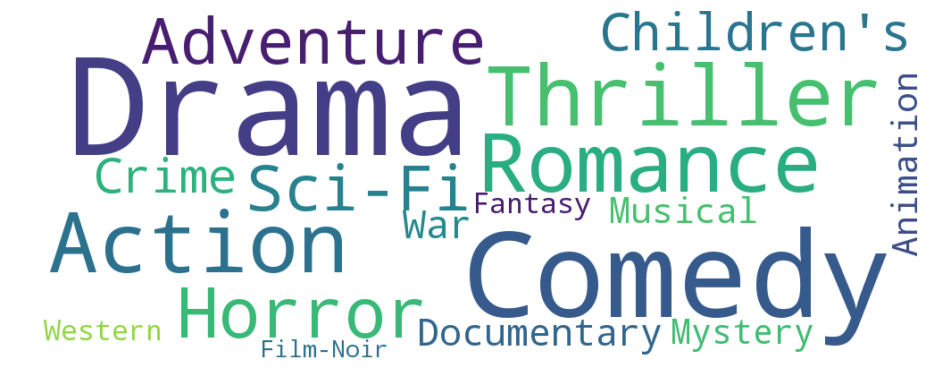

In [26]:
# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genre_counter)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Content based collaborative filtering
Like we said in the course, the metadata attached to an item can be used to compute similarities, and recommend to a user similar items to what he saw.
We saw briefly how can we use TF-IDF to compute item vectors from descriptions, categories, ... and then use the similarity between item vectors (cosine similarity for instance).
We are going to do that here with movies genres.

In [27]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', min_df=0)
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(3883, 20)

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.30552517, 0.19737232, 0.26019351],
       [0.30552517, 1.        , 0.        , 0.        ],
       [0.19737232, 0.        , 1.        , 0.43309256],
       [0.26019351, 0.        , 0.43309256, 1.        ]])

We now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the most similar movies based on the cosine similarity score.

In [30]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def recommendations_from_similarities(sims, title, k=10):
    idx = indices[title]
    sim_scores = list(enumerate(sims[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[:k+1]
    # the most similar movie to a given one will always be itself, so we skip that one
    movie_indices = [i[0] for i in sim_scores if i[0] != idx]
    return titles.iloc[movie_indices]

In [31]:
recommendations_from_similarities(cosine_sim, 'Matrix, The (1999)').head(10)

170                Johnny Mnemonic (1995)
283              Nemesis 2: Nebula (1995)
585     Terminator 2: Judgment Day (1991)
683                           Solo (1996)
738                   Arrival, The (1996)
1024            Lawnmower Man, The (1992)
1220               Terminator, The (1984)
1533                      Face/Off (1997)
1763                 Lost in Space (1998)
2531                      eXistenZ (1999)
Name: title, dtype: object

In [32]:
recommendations_from_similarities(cosine_sim, 'Toy Story (1995)').head(10)

1050            Aladdin and the King of Thieves (1996)
2072                          American Tail, An (1986)
2073        American Tail: Fievel Goes West, An (1991)
2285                         Rugrats Movie, The (1998)
2286                              Bug's Life, A (1998)
3045                                Toy Story 2 (1999)
3542                             Saludos Amigos (1943)
3682                                Chicken Run (2000)
3685    Adventures of Rocky and Bullwinkle, The (2000)
12                                        Balto (1995)
Name: title, dtype: object

In [33]:
recommendations_from_similarities(cosine_sim, 'Saving Private Ryan (1998)').head(10)

108                Braveheart (1995)
461            Heaven & Earth (1993)
1204        Full Metal Jacket (1987)
1214     Boat, The (Das Boot) (1981)
1222                    Glory (1989)
1545                G.I. Jane (1997)
2358       Thin Red Line, The (1998)
2993         Longest Day, The (1962)
3559            Flying Tigers (1942)
3574    Fighting Seabees, The (1944)
Name: title, dtype: object

### Collaborative Filtering
Now we are going to apply what we learned about item-item and user-user collaborative filtering.

First we need to split our data to test and train datasets, so we can evaluate what we are doing.

In [34]:
# Fill NaN values in user_id and movie_id column with 0
ratings['user_id'] = ratings['user_id'].fillna(0)
ratings['movie_id'] = ratings['movie_id'].fillna(0)

# Replace NaN values in rating column with average of all values
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

In [35]:
# split into 80% train and 20% test
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ratings, test_size=0.2)

In [36]:
import scipy

def to_sparse_matrix(df, rating_col="rating"):
    return scipy.sparse.csr_matrix((df[rating_col], (df['user_id'], df['movie_id'])))

In [37]:
train_sparse = to_sparse_matrix(train_data)

In [38]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_sim = 1 - pairwise_distances(train_sparse, metric='cosine')
user_sim[np.isnan(user_sim)] = 0

print(user_sim[:4, :4])

[[1.         0.         0.         0.        ]
 [0.         1.         0.08960237 0.12238962]
 [0.         0.08960237 1.         0.14239972]
 [0.         0.12238962 0.14239972 1.        ]]


In [39]:
# Item Similarity Matrix

item_sim = 1 - pairwise_distances(train_sparse.T, metric='cosine')
item_sim[np.isnan(item_sim)] = 0

print(item_sim[:4, :4])

[[1.         0.         0.         0.        ]
 [0.         1.         0.30824813 0.20905832]
 [0.         0.30824813 1.         0.19824211]
 [0.         0.20905832 0.19824211 1.        ]]


In [40]:
recommendations_from_similarities(item_sim, 'Matrix, The (1999)').head(10)

223                   Dream Man (1995)
2700                 Yards, The (1999)
2706                    Head On (1998)
2683         Outrageous Fortune (1987)
2395             Trick or Treat (1986)
1517    Speed 2: Cruise Control (1997)
785            Somebody to Love (1994)
2580        Son of Frankenstein (1939)
2716            Tales of Terror (1962)
3253                  3 Strikes (2000)
Name: title, dtype: object

In [41]:
recommendations_from_similarities(item_sim, 'Toy Story (1995)').head(10)

1                         Jumanji (1995)
2                Grumpier Old Men (1995)
3               Waiting to Exhale (1995)
4     Father of the Bride Part II (1995)
5                            Heat (1995)
6                         Sabrina (1995)
7                    Tom and Huck (1995)
8                    Sudden Death (1995)
9                       GoldenEye (1995)
10        American President, The (1995)
Name: title, dtype: object

In [42]:
recommendations_from_similarities(item_sim, 'Saving Private Ryan (1998)').head(10)

2734                 Pelican Brief, The (1993)
2369                      Outside Ozona (1998)
1958                             Mafia! (1998)
2987                             Oxygen (1999)
2013                  Mighty Ducks, The (1992)
1183    Good, The Bad and The Ugly, The (1966)
2396                      Deadly Friend (1986)
2070                Secret of NIMH, The (1982)
1096                       Palookaville (1996)
1674                            Twisted (1996)
Name: title, dtype: object

In [43]:
# Adjusted cosine similarity
# We need to substract average rating for each item from its rating
train_data_adj = train_data.join(train_data.groupby('movie_id')['rating'].mean(), on='movie_id', rsuffix='_mean')

In [44]:
train_data_adj["adjusted_rating"] = train_data_adj["rating"] - train_data_adj["rating_mean"]

In [45]:
train_data_adj.head()

,user_id,movie_id,rating,timestamp,rating_mean,adjusted_rating
957909,5780,782,3,958157061,2.652174,0.347826
261951,1599,357,3,974732560,3.745197,-0.745197
746818,4457,950,5,965240790,4.256198,0.743802
292378,1741,1396,4,974707758,3.714959,0.285041
125167,803,733,3,975395877,3.738967,-0.738967


In [46]:
train_adj_sparse = to_sparse_matrix(train_data_adj, rating_col="adjusted_rating")

In [47]:
# Item Similarity Matrix

item_sim_adj = 1 - pairwise_distances(train_adj_sparse.T, metric='cosine')
item_sim_adj[np.isnan(item_sim_adj)] = 0

print(item_sim_adj[:4, :4])

[[1.         0.         0.         0.        ]
 [0.         1.         0.07387505 0.03389636]
 [0.         0.07387505 1.         0.02043324]
 [0.         0.03389636 0.02043324 1.        ]]


In [48]:
recommendations_from_similarities(item_sim_adj, 'Saving Private Ryan (1998)').head(10)

2070                Secret of NIMH, The (1982)
2243           Children of a Lesser God (1986)
1183    Good, The Bad and The Ugly, The (1966)
2929            Dreaming of Joseph Lees (1998)
2067               Nutty Professor, The (1963)
2739                  Universal Soldier (1992)
2020           Rescuers Down Under, The (1990)
1096                       Palookaville (1996)
1088          Streetcar Named Desire, A (1951)
1811                          Lawn Dogs (1997)
Name: title, dtype: object

### Writing the prediction functions
Now we are going to write a couple of functions that will predict ratings for user, item pairs in the test set.
We will be using the formulas from the course, to take the weighted average of ratings from:
* The items that the user already rated, weighted by similarity to the target item
* The ratings that the other users gave to the item, weighted by the similarity with the target user

In [49]:
from scipy import sparse

def predict_user_user_cf(train_ratings, test_ratings, similarity_matrix):
    mean_user_ratings = train_data.groupby('user_id')['rating'].mean()
    
    train_ratings = train_ratings.join(mean_user_ratings, on='user_id', rsuffix='_user_mean')
    test_ratings = test_ratings.join(mean_user_ratings, on='user_id', rsuffix='_user_mean')
    
    train_ratings["ratings_adjusted_user_mean"] = train_ratings["rating"] - train_ratings["rating_user_mean"]
    train_ratings_sparse = to_sparse_matrix(train_ratings, "ratings_adjusted_user_mean")
    
    ratings_weighted_by_user_sim = sparse.csr_matrix.dot(similarity_matrix, train_ratings_sparse) / np.sum(similarity_matrix, axis=1, keepdims=True)
    
    indices = np.array([[user_id, movie_id] for user_id in range(ratings_weighted_by_user_sim.shape[0]) for movie_id in range(ratings_weighted_by_user_sim.shape[1])])
    predicted_ratings = ratings_weighted_by_user_sim.flatten()
    
    predicted_ratings_df = pd.DataFrame({
        "user_id": indices[:, 0],
        "movie_id": indices[:, 1],
        "predicted_rating": predicted_ratings,
    })
    
    predicted_ratings_df = pd.merge(predicted_ratings_df, test_ratings, on=["user_id", "movie_id"])
    predicted_ratings_df["predicted_rating"] = predicted_ratings_df["predicted_rating"] + predicted_ratings_df["rating_user_mean"]
    return predicted_ratings_df

In [50]:
user_user_predictions = predict_user_user_cf(train_data, test_data, user_sim)
user_user_predictions.head()

,user_id,movie_id,predicted_rating,rating,timestamp,rating_user_mean
0,1,531,4.310666,4,978302149,4.302326
1,1,594,4.337463,4,978302268,4.302326
2,1,608,4.508958,4,978301398,4.302326
3,1,914,4.367658,3,978301968,4.302326
4,1,919,4.480900,4,978301368,4.302326


In [51]:
def predict_item_item_cf(train_ratings, test_ratings, similarity_matrix):
    mean_item_ratings = train_data.groupby('movie_id')['rating'].mean()
    
    train_ratings = train_ratings.join(mean_item_ratings, on='movie_id', rsuffix='_item_mean')
    test_ratings = test_ratings.join(mean_item_ratings, on='movie_id', rsuffix='_item_mean')
    
    train_ratings["ratings_adjusted_item_mean"] = train_ratings["rating"] - train_ratings["rating_item_mean"]
    train_ratings_sparse = to_sparse_matrix(train_ratings, "ratings_adjusted_item_mean")
    
    ratings_weighted_by_item_sim = sparse.csr_matrix.dot(train_ratings_sparse, similarity_matrix) / np.sum(similarity_matrix, axis=0, keepdims=True)
    
    indices = np.array([[user_id, movie_id] for user_id in range(ratings_weighted_by_item_sim.shape[0]) for movie_id in range(ratings_weighted_by_item_sim.shape[1])])
    predicted_ratings = ratings_weighted_by_item_sim.flatten()
    
    predicted_ratings_df = pd.DataFrame({
        "user_id": indices[:, 0],
        "movie_id": indices[:, 1],
        "predicted_rating": predicted_ratings,
    })
    
    predicted_ratings_df = pd.merge(predicted_ratings_df, test_ratings, on=["user_id", "movie_id"])
    predicted_ratings_df["predicted_rating"] = predicted_ratings_df["predicted_rating"] + predicted_ratings_df["rating_item_mean"]
    return predicted_ratings_df

In [52]:
item_item_predictions = predict_item_item_cf(train_data, test_data, item_sim)

We are just going to replace nans here by the average predictions.

In [53]:
item_item_predictions['predicted_rating'] = item_item_predictions['predicted_rating'].fillna(item_item_predictions['predicted_rating'].mean())

### Evaluation
We are going to evaluate our methods on the test set, using the mean absolute error metric.
Which is as follows:
$$\mathit{MAE} =\sqrt{\frac{1}{N} \sum |x_i -\hat{x_i}|}$$

This just measures the average deviation from the ground truth.

In [54]:
from sklearn.metrics import mean_absolute_error

In [55]:
print("MAPE of user-user cf", mean_absolute_error(user_user_predictions["rating"], user_user_predictions["predicted_rating"]))
print("MAPE of item-item cf", mean_absolute_error(item_item_predictions["rating"], item_item_predictions["predicted_rating"]))

MAPE of user-user cf 0.8057832614481694
MAPE of item-item cf 0.7648158769984711


We see here that item-item performs a bit better than user-user, at least on this dataset.
But to have a frame of reference, let's see what is the performance of a dumb predictor that just predicts the average rating

In [56]:
test_data["average_rating"] = train_data["rating"].mean()
print("MAPE of average", mean_absolute_error(test_data["rating"], test_data["average_rating"]))

MAPE of average 0.9349309116394672


/Users/ma.benhalloum/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


So we are indeed better than the baseline !

## Matrix Factorization
Now we are going to try our hand with matrix factorization techniques, we are going to use the **surprise** package which just bundles together a bunch of algorithms in a easy to use manner, check it out [here](https://surprise.readthedocs.io/en/stable/getting_started.html)

First we are going to build the dataset:

In [57]:
from surprise import Dataset
from surprise import Reader
import surprise

In [58]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

trainset, testset = surprise.model_selection.train_test_split(data, test_size=.2)

Then we are going to use the SVD algorithm, and compute the MAE on the test data, here the train - test split is not the same as previously (for ease of use with the surprise package) but it still gives us an idea of how we perform.

In [ ]:
from surprise import SVD

# We'll use the famous SVD algorithm.
algo = SVD(n_factors=10, n_epochs=30, verbose=True)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10


Let's compute the MAE

In [ ]:
from surprise import accuracy

accuracy.mae(predictions)

Seems it's better than our previous approaches ! Let's inspect the factors that we learned

In [ ]:
item_factors = algo.qi
item_factors_sim = 1 - pairwise_distances(item_factors, metric='cosine')

In [ ]:
item_factors_sim.shape

We need to redefine our function **recommendations_from_similarities** because of the specifics of the suprise package.

In [ ]:
id_to_title = dict((row["movie_id"], row["title"]) for _, row in movies.iterrows())
title_to_id = dict((row["title"], row["movie_id"]) for _, row in movies.iterrows())

# Function that get movie recommendations based on the cosine similarity score of movie genres
def recommendations_from_similarities_surprise(dataset, sims, title, k=10):
    movie_id = title_to_id[title]
    idx = dataset.to_inner_iid(movie_id)
    sim_scores = list(enumerate(sims[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[:k+1]
    # the most similar movie to a given one will always be itself, so we skip that one
    movies = [id_to_title[dataset.to_raw_iid(i[0])] for i in sim_scores if i[0] != idx]
    return movies

In [ ]:
recommendations_from_similarities_surprise(trainset, item_factors_sim, 'Matrix, The (1999)')

In [ ]:
recommendations_from_similarities_surprise(trainset, item_factors_sim, 'Toy Story (1995)')

In [ ]:
recommendations_from_similarities_surprise(trainset, item_factors_sim, 'Saving Private Ryan (1998)')